# Quantum Key Distribution - E91

Original code, which explained the BB84 protocol, sourced from: 

https://qiskit.org/textbook/ch-algorithms/quantum-key-distribution.html

A relevant discussion of E91: 

https://en.wikipedia.org/wiki/Quantum_key_distribution#E91_protocol:_Artur_Ekert_.281991.29

A listing of available Qiskit gates:

https://qiskit.org/textbook/ch-states/single-qubit-gates.html#1.2-The-Y-&-Z-gates--

A video on the CHSH inequality, which is pertinent to why E91 is useful:

https://www.youtube.com/watch?v=sUQYSy6C1aA

## Contents

1. Introduction
2. Theory Demonstration
2. Protocol Overview
3. Qiskit Example
4. What happens when Eve entangles a third qubit?
5. What happens when the angle intervals are changed?

## 1. Introduction

When Alice and Bob want to communicate a secret message (such as Bob’s online banking details) over an insecure channel (such as the internet), its essential to encrypt the message. Since cryptography is a large area and almost all of it is outside the scope of this textbook, we will have to believe that Alice and Bob having a secret key that no-one else knows is useful and allows them to communicate using symmetric-key cryptography.

If Alice and Bob want to use Eve’s classical communication channel to share their key, it is impossible to tell if Eve has made a copy of this key for herself- they must place complete trust in Eve that she is not listening. If, however, Eve provides a quantum communication channel, Alice and Bob no longer need to trust Eve at all- they will know if she tries to read Bob’s message before it gets to Alice.

For some readers, it may be useful to give an idea of how a quantum channel may be physically implemented. An example of a classical channel could be a telephone line; we send electric signals through the line that represent our message (or bits). A proposed example of a quantum communication channel could be some kind of fibre-optic cable, through which we can send individual photons (particles of light). Photons have a property called _polarisation,_ and this polarisation can be one of two states. We can use this to represent a qubit.


## 2. Theory Demonstration

The protocol makes use of the fact that measuring a qubit can change its state. If Alice sends Bob a qubit, and an eavesdropper (Eve) tries to measure it before Bob does, there is a chance that Eve’s measurement will change the state of the qubit and Bob will not receive the qubit state Alice sent.  

In [1]:
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint, choice
import numpy as np
print("Imports Successful")

Imports Successful


If Alice prepares a qubit in the state $|+\rangle$ (`0` in the X-basis), and Bob measures it in the X-basis, Bob is sure to measure `0`:

┌───┐ ░ ┌───┐┌─┐
q_0: ┤ H ├─░─┤ H ├┤M├
     └───┘ ░ └───┘└╥┘
c: 1/══════════════╩═
                   0

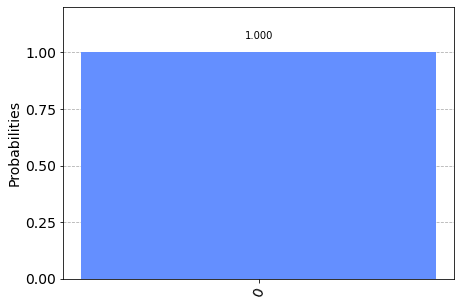

In [2]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
qc.barrier()
# Alice now sends the qubit to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw())
qasm_sim = Aer.get_backend('qasm_simulator')
job = qasm_sim.run(assemble(qc))
plot_histogram(job.result().get_counts())

But if Eve tries to measure this qubit in the Z-basis before it reaches Bob, she will change the qubit's state from $|+\rangle$ to either $|0\rangle$ or $|1\rangle$, and Bob is no longer certain to measure `0`:

┌───┐┌─┐ ░ ┌───┐┌─┐
q_0: ┤ H ├┤M├─░─┤ H ├┤M├
     └───┘└╥┘ ░ └───┘└╥┘
c: 1/══════╩══════════╩═
           0          0

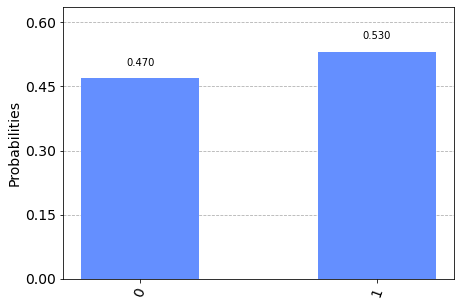

In [3]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
# Alice now sends the qubit to Bob
# but Eve intercepts and tries to read it
qc.measure(0, 0)
qc.barrier()
# Eve then passes this on to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw())
qasm_sim = Aer.get_backend('qasm_simulator')
job = qasm_sim.run(assemble(qc))
plot_histogram(job.result().get_counts())

We can see here that Bob now has a 50% chance of measuring `1`, and if he does, he and Alice will know there is something wrong with their channel. 

This effect occurs in any given non-identical pair of measurement bases:
- The measured result of a mismatched basis will not always match the encoded bit.
- The act of measurement changes a qubit in a predictable way.

Another key concept in the E91 protocol is the EPR pair. An EPR pair is a pair of maximally entangled qubits. Qubits in an EPR pair have the interesting property that after measuring one of them in a given basis, if the paired qubit is measured in that same basis, that second measurement will, with 100% certainty, report a known value. If, however, the second qubit is measured in a different basis, the second measurement will report each possible outcome with known probabilities.

By way of example, let us generate many instances of the $(1/sqrt(2))(|00\rangle + |11\rangle)$ EPR pair and measure each pair's qubits.

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

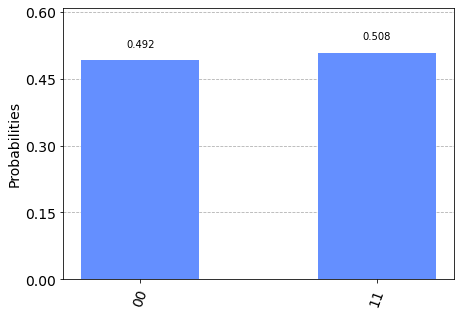

In [4]:
# Generate a quantum circuit
qc = QuantumCircuit(2,2)
# Entangle an EPR pair
qc.h(0)
qc.cx(0,1)
# Measure each qubit in turn
qc.measure(0,0)
qc.measure(1,1)
# Display results
display(qc.draw())
qasm_sim = Aer.get_backend('qasm_simulator')
job = qasm_sim.run(assemble(qc))
plot_histogram(job.result().get_counts())

Note that the two outcomes are $|00\rangle$ and $|11\rangle$, in equal amounts. When the first bit is measured a 0, the second is measured a 0; likewise with 1.

But what happens when the two measurements of the qubits in an EPR pair are taken on different bases? 

First, let us define functions for measuring in various bases.

In [5]:
# Create the X-measurement function:
def x_measurement(qc, qubit, cbit):
    """Measure 'qubit' in the X-basis, and store the result in 'cbit'"""
    qc.h(qubit)
    qc.measure(qubit, cbit)

# Create the X-measurement function:
def y_measurement(qc, qubit, cbit):
    """Measure 'qubit' in the Y-basis, and store the result in 'cbit'"""
    qc.y(qubit)
    qc.measure(qubit, cbit)

# Create the X-measurement function:
def z_measurement(qc, qubit, cbit):
    """Measure 'qubit' in the Y-basis, and store the result in 'cbit'"""
    qc.measure(qubit, cbit)

Additionally, let us create a macro for testing in each such measurement basis.

In [6]:
def measure_epr_pair_in_given_bases(measurement_function_1, measurement_function_2):
    # Generate a quantum circuit
    qc = QuantumCircuit(2,2)
    # Entangle an EPR pair
    qc.h(0)
    qc.cx(0,1)
    # Measure each qubit in its chosen basis
    measurement_function_1(qc, 0, 0)
    measurement_function_1(qc, 1, 1)
    display(qc.draw())
    qasm_sim = Aer.get_backend('qasm_simulator')
    job = qasm_sim.run(assemble(qc))
    histogram_res = job.result().get_counts()
    return histogram_res

Let us test when the bases are aligned.

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

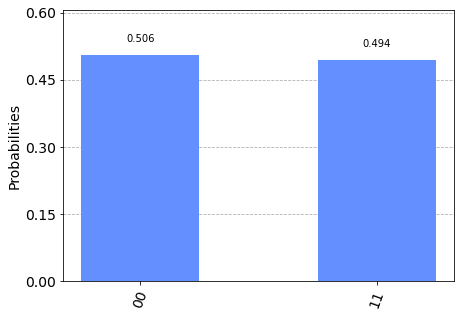

In [38]:
histogram_res = measure_epr_pair_in_given_bases(z_measurement, z_measurement)
plot_histogram(histogram_res)

Now, let us test when the bases are $1\pi/4$ radians from one another.

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

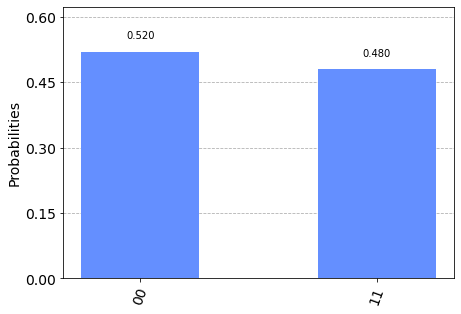

In [41]:
histogram_res = measure_epr_pair_in_given_bases(z_measurement, z_measurement)
plot_histogram(histogram_res)

Now, let us test when the bases are $2\pi/4$ radians from one another.

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

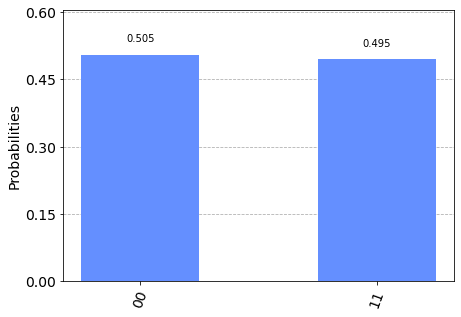

In [40]:
histogram_res = measure_epr_pair_in_given_bases(z_measurement, z_measurement)
plot_histogram(histogram_res)

Now, let us test when the bases are $3\pi/4$ radians from one another.

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

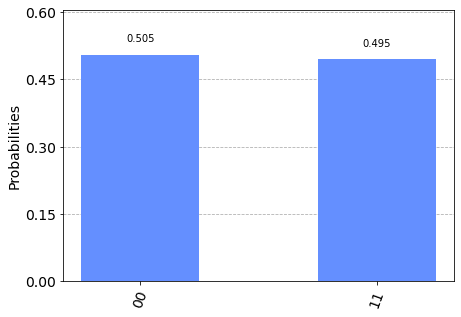

In [40]:
histogram_res = measure_epr_pair_in_given_bases(z_measurement, z_measurement)
plot_histogram(histogram_res)

Clearly, the results will only ever match up perfectly when the bases match.

The concept critical to the E91 protocol is the [CHSH inequality](https://en.wikipedia.org/wiki/CHSH_inequality), which describes the relationship between measurements of members of EPR pairs taken in bases rotated by known angles. The critical aspects are:
- If you measure one qubit in a basis, and you measure its EPR partner in a basis rotated by $\theta$, then the probability that you will measure the same outcome for both qubits in $\cos^2(\theta)$. 
- If you measure two qubits in mismatching bases, and they are NOT in an EPR pair, you will not find such a correlation.
- If you measure two qubits in mismatching bases, and they have been entangled with a third qubit, you will not find such a correlation.

## 3. Protocol Overview

The E91 quantum key distribution protocol involves distributing EPR pairs to Alice and Bob, letting them each measure their qubits along privately-chosen bases, revealing their bases to one another, constructing a valid key from qubit measurements corresonding to matching basis choices, and using the results from non-matching choices in heuristic analyses to find eavesdroppers.

For the sake of simplicity, all EPR pairs here will be in symmetrically entangled states (like $(1/sqrt(2))(|00\rangle + |11\rangle)$ or $(1/sqrt(2))(|++\rangle + |--\rangle)$) rather than complementarily entangled states (like $(1/sqrt(2))(|01\rangle + |10\rangle)$ or $(1/sqrt(2))(|+-\rangle + |-+\rangle)$). (If the pairs were in complementarily entangled states, a simple bit flip post-measurement on Bob's part would be sufficient to keep the protocol intact.)

It is assumed that Alice and Bob have agreed beforehand on lengths of random strings to be generated, number of qubits to destroy in testing, the encoding procedures for each basis, etc.

Detailed steps for the E91 protocol are below.

In [9]:
qubits_count = 50
check_count = 5

**- Step 1**

Alice and Bob choose strings of random bits to be their basis choices. Alice chooses from the bases $Z_0$, $Z_{\pi/8}$, $Z_{\pi/4}$, while Bob chooses from the bases $Z_{-\pi/8}$, $Z_0$, $Z_{\pi/8}$, where $Z_\theta$ is the $\{|+\rangle,|-\rangle\}$ basis rotated by $\theta$.

Let the basis choices $Z_{-\pi/8}$, $Z_0$, $Z_{\pi/8}$, and $Z_{\pi/4}$ correspond to the integers 0 to 3.

In [40]:
alice_basis_choices = ''.join([str(randint(1, 4)) for i in range(qubits_count)])
bob_basis_choices = ''.join([str(randint(0, 3)) for i in range(qubits_count)])
print("Alice's basis choices are:\n", alice_basis_choices)
print("Bob's basis choices are:\n", bob_basis_choices)

Alice's basis choices are:
 11113311123112132221112232112322211123221123133222
Bob's basis choices are:
 20010220222110002211002112011111222012111102201100


Alice and Bob keep these pieces of information private to themselves. 

**- Step 2**

Alice and Bob measure EPR pairs along their previously chosen bases. It does not matter where the EPR pairs come from - they can come from Alice, they can come from Bob, or they can come from an external source Eve. Regardless the EPR pairs' providence, they are measured by Alice and Bob.

In Qiskit, this process will be modeled by generating EPR pair objects and having Alice and Bob measure them. Here, this is modeled by probabalistically generating outcomes, according to pairs of Alice and Bob basis choices.

In [11]:
alice_measurements = []
bob_measurements = []
for alice_basis, bob_basis in zip(alice_basis_choices, bob_basis_choices):
    alice_basis, bob_basis = map(int, [alice_basis, bob_basis])
    # The first measurement is always random:
    primary_measurement = randint(0, 2)
    secondary_measurement = "X"
    # If measurements are aligned:
    if alice_basis == bob_basis:
        secondary_measurement = primary_measurement
    # If measurements are pi/4 apart
    elif abs(alice_basis - bob_basis) == 1:
        pass
    # If measurements are pi/2 apart
    elif abs(alice_basis - bob_basis) == 2:
        secondary_measurement = randint(0, 2)
    # If measurements are 3pi/4 apart
    elif abs(alice_basis - bob_basis) == 3:
        pass
    # Store the measurements
    alice_measurements.append(str(primary_measurement))
    bob_measurements.append(str(secondary_measurement))
alice_measurements = ''.join(alice_measurements)
bob_measurements = ''.join(bob_measurements)
print("Alice's measurements are:\n", alice_measurements)
print("Bob's measurements are:\n", bob_measurements)

Alice's measurements are:
 01000100100101111011000110101111101010100101000100
Bob's measurements are:
 X0X0XXX11XX100X1XX001XX1XX11XXXX10XXX000XXXXXX0XX0


**- Step 3**

Alice and Bob reveal their bases to one another and use the new information to generate a secret key from those measurements that were taken in matching bases.

In [12]:
alice_secret_key = ''.join([measurement for measurement, a_choice, b_choice in 
                            zip(alice_measurements, 
                                alice_basis_choices, 
                                bob_basis_choices)
                            if a_choice == b_choice])
bob_secret_key = ''.join([measurement for measurement, a_choice, b_choice in 
                          zip(alice_measurements,
                              alice_basis_choices, 
                              bob_basis_choices)
                          if a_choice == b_choice])
print("Alice's secret key is: \n", alice_secret_key)
print("Bob's secret key is: \n", bob_secret_key)

Alice's secret key is: 
 1101110000
Bob's secret key is: 
 1101110000


**- Step 4**

Alice and Bob use their unused measurements (those from mismatched bases) to test [Bell's theorem](https://en.wikipedia.org/wiki/Bell%27s_theorem).

## 4. Qiskit Example

Let’s first see how the protocol works when no-one is listening in. As always, let's start by importing everything we need:

To generate pseudo-random keys, we will use the `randint` function from numpy. To make sure you can reproduce the results on this page, we will set the seed to 0:

In [13]:
np.random.seed(seed=0)

We will call the length of Alice's initial message `n`. In this example, Alice will send a message 100 qubits long:

In [14]:
n = 100

### 4.1 Step 1:

#### Step 1a:

Alice generates the random bits of her secret key:

In [15]:
np.random.seed(seed=0)
alice_bits = randint(2, size=n)
print(alice_bits)

[0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0
 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0
 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0]


At the moment, the set of bits '`alice_bits`' is only known to Alice. We will keep track of what information is only known to Alice, what information is only known to Bob, and what has been sent over Eve's channel in a table like this:

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |       &nbsp;    |

#### Step 1b:

Alice then encodes her secret key and sends it to Bob. 
She encodes each 0 as a $|0\rangle$, and she encodes each 1 as a $|+\rangle$.

The function `encode_message` below, creates a list of `QuantumCircuit`s, each representing a single qubit in Alice's message:

In [16]:
def encode_message(bits):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        # If bit is 0, encode it as a (0)-ket.
        if bits[i] == 0: # Prepare qubit in Z-basis
            pass
        # If bit is 1, encode it as a (+)-ket. 
        else: # Prepare qubit in X-basis
            qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

In [17]:
message = encode_message(alice_bits)

We can confirm that the first qubit of `message` is in the state $|0\rangle$, corresponding to a 0 bit:

In [18]:
print("Alice's first bit is {}, encoded as shown.".format(alice_bits[0]))
message[0].draw()

Alice's first bit is 0, encoded as shown.


░ 
q_0: ─░─
      ░ 
c: 1/═══

We can confirm that the second qubit of `message` is in the state $|+\rangle$, corresponding to a 1 bit:

In [19]:
print("Alice's first bit is {}, encoded as shown.".format(alice_bits[1]))
message[1].draw()

Alice's first bit is 1, encoded as shown.


┌───┐ ░ 
q_0: ┤ H ├─░─
     └───┘ ░ 
c: 1/════════

This message of qubits is then sent to Bob over Eve's quantum channel:

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |                 |
|      message      |     message      |     message     |

### 4.2 Step 2:

#### Step 2a

Bob randomly selects between the Binary basis and the Hadamar basis as the basis with which he will measure each qubit that Alice sends him. Letting `B` represent the Binary basis and letting `H` represent Hadamar basis, he might use the bases:

In [20]:
def choose_n_bases(n):
    return ''.join([['B', 'H'][i] for i in randint(2, size=n)])

In [21]:
bob_bases = choose_n_bases(n)
print("Bob's chosen bases are:\n", bob_bases)

Bob's chosen bases are:
 HBBHBBBHHBHBBBBBHBHBHHHHHBHHHHBHHBBHBBBBHHBBHBHHHHBBBHBHHHBHBBHBHHBBHBHBHBHBHBBBHBHBHBBBBBHBBHBBBHBB


`bob_bases` stores Bob's choice for which basis he measures each qubit in.

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |                 |
|      message      |     message      |     message     |
|                   |                  |    bob_bases    |

Bob keeps his basis set choices private for now.

#### Step 2b

Bob measures each of Alice's sent qubits along the corresponding basis that he chose for it beforehand. 

Below, the function `measure_message`, applies the corresponding measurement and simulates the result of measuring each qubit. We store the measurement results in `bob_results`.

In [22]:
def measure_message(message, bases):
    backend = Aer.get_backend('qasm_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == "B": # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == "H": # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        qasm_sim = Aer.get_backend('qasm_simulator')
        qobj = assemble(message[q], shots=1, memory=True)
        result = qasm_sim.run(qobj).result()
        measured_bit = int(result.get_memory()[0])
        if bases[q] == "H" and measured_bit == 1:
            measurements.append("-")
        elif bases[q] == "B" and measured_bit == 1:
            measurements.append("1")
        elif bases[q] == "H" and measured_bit == 0:
            measurements.append("+")
        elif bases[q] == "B" and measured_bit == 0:
            measurements.append("0") 
    return ''.join(measurements)

In [23]:
bob_measurements = measure_message(message, bob_bases)
print(bob_measurements)

-01+011++1+00100-0-0+++-+0++++1++01+0010++01+0++-+001+1-++0+00+0++00+0+1-0+1+010-0+1+11010+10-100+10


We can see that the circuit in `message[7]` (representing the 0th qubit) has had an $X$-measurement added to it by Bob:

In [24]:
message[7].draw()

┌───┐ ░ ┌───┐┌─┐
q_0: ┤ H ├─░─┤ H ├┤M├
     └───┘ ░ └───┘└╥┘
c: 1/══════════════╩═
                   0

Since Bob has by chance chosen to measure in the same basis Alice encoded the qubit in, Bob is guaranteed to get the result `0`. For the 6th qubit (shown below), Bob's random choice of measurement is not the same as Alice's, and Bob's result has only a 50% chance of matching Alices'. 

In [25]:
message[6].draw()

┌───┐ ░ ┌─┐
q_0: ┤ H ├─░─┤M├
     └───┘ ░ └╥┘
c: 1/═════════╩═
              0

Bob keeps his results private.

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge     |
|:-----------------:|:------------------:|:-------------------:|
|     alice_bits    |                    |                     |
|      message      |       message      |     message         |
|                   |                    |    bob_bases        |
|                   |                    |   bob_measurements  |

#### Step 3a

When Bob measures a $|1\rangle$ or a $|-\rangle$, he knows for certain that Alice sent him a $|+\rangle$ or $|0\rangle$, respectively.
However, when Bob measures a $|0\rangle$ or a $|+\rangle$, he knows nothing for certain about the qubit Alice just sent him.

Thus, Bob infers those sent qubits that he can definitely know, i.e. those corresponding to measurement results of $|1\rangle$ or $|-\rangle$. He leaves the other bits empty.

In [26]:
def bob_infers_sent_qubits_from_measurements(bobs_measurements):
    bobs_inferred_sent_qubits = []
    for measurement in bobs_measurements:
        if measurement in "0+":
            bobs_inferred_sent_qubits.append("?")
        elif measurement == "1":
            bobs_inferred_sent_qubits.append("+")
        elif measurement == "-":
            bobs_inferred_sent_qubits.append("0")
    return "".join(bobs_inferred_sent_qubits)

In [27]:
bobs_inferred_sent_qubits = bob_infers_sent_qubits_from_measurements(bob_measurements)
print("Bob infers that Alice sent him the qubits:\n", bobs_inferred_sent_qubits)

Bob infers that Alice sent him the qubits:
 0?+??++??+???+??0?0????0??????+???+???+????+????0???+?+0???????????????+0??+??+?0??+?++?+??+?0+???+?


| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge        |
|:-----------------:|:------------------:|:----------------------:|
|     alice_bits    |                    |                        |
|      message      |       message      |     message            |
|                   |                    |    bob_bases           |
|                   |                    |   bob_measurements     |
|                   |                    |   bob_inferred_qubits  |


#### Step 3b

Bob, knowing that Alice is encoding `1` as $|+\rangle$ and `0` as $|0\rangle$, converts his inferred qubits into a partial copy of the secret key that encoded those qubits.

In [28]:
def decode_known_qubits(bob_inferred_sent_qubits):
    return "".join(['1' if q == '+' else q for q in bobs_inferred_sent_qubits])

In [29]:
bob_partial_key = decode_known_qubits(bobs_inferred_sent_qubits)

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge        |
|:-----------------:|:------------------:|:----------------------:|
|     alice_bits    |                    |                        |
|      message      |       message      |     message            |
|                   |                    |    bob_bases           |
|                   |                    |   bob_measurements     |
|                   |                    |   bob_inferred_qubits  |
|                   |                    |   bob_partial_key      |


### 4.4 Step 4:

After this, Alice reveals (through Eve's channel) which qubits were encoded in which basis: 

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge        |
|:-----------------:|:------------------:|:----------------------:|
|     alice_bits    |                    |                        |
|      message      |       message      |     message            |
|                   |                    |    bob_bases           |
|                   |                    |   bob_measurements     |
|                   |                    |   bob_inferred_qubits  |
|                   |                    |   bob_partial_key      |
|                   |     alice_bases    |   alice_bases          |

And Bob reveals which basis he measured each qubit in:

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge        |
|:-----------------:|:------------------:|:----------------------:|
|     alice_bits    |                    |                        |
|      message      |       message      |     message            |
|                   |                    |    bob_bases           |
|                   |                    |   bob_measurements     |
|                   |                    |   bob_inferred_qubits  |
|                   |                    |   bob_partial_key      |
|                   |     alice_bases    |   alice_bases          |
|     bob_bases     |      bob_bases     |                        |

If Bob happened to measure a bit in the same basis Alice prepared it in, this means the entry in `bob_partial_key` will match the corresponding entry in `alice_bits`, and they can use that bit as part of their key. If they measured in different bases, Bob's result is random, and they both throw that entry away. Alice and Bob both discard the useless bits, and use the remaining bits to form their secret keys.

Here is a function `remove_garbage` that does this for us:

In [30]:
def remove_garbage(alice_bits, bob_partial_key):
    successfully_determined_bits = ['0' if bit == "?" else '1' for bit in bob_partial_key]
    alice_sifted_key = []
    bob_sifted_key = []
    for alice_bit, bob_bit, bit_is_valid in zip(alice_bits, bob_partial_key, successfully_determined_bits):
        if bit_is_valid == "1":
            alice_sifted_key.append(alice_bit)
            bob_sifted_key.append(bob_bit)
    alice_secret_key = ''.join([str(i) for i in alice_sifted_key])
    bob_secret_key = ''.join(bob_sifted_key)
    return alice_secret_key, bob_secret_key

In [31]:
alice_secret_key, bob_secret_key = remove_garbage(alice_bits, bob_partial_key)
print("A's Secret Key:", alice_secret_key)
print("B's Secret Key:", bob_secret_key)

A's Secret Key: 011111000111101101011011111011
B's Secret Key: 011111000111101101011011111011



| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge        |
|:-----------------:|:------------------:|:----------------------:|
|     alice_bits    |                    |                        |
|      message      |       message      |     message            |
|                   |                    |    bob_bases           |
|                   |                    |   bob_measurements     |
|                   |                    |   bob_inferred_qubits  |
|                   |                    |   bob_partial_key      |
|                   |     alice_bases    |   alice_bases          |
|     bob_bases     |      bob_bases     |                        |
| alice_secret_key  |                    |     bob_secret_key     |

### 4.5 Step 5:

Finally, Bob and Alice compare a random selection of the bits in their keys to make sure the protocol has worked correctly:

In [32]:
def sample_bits(bits, selection):
    # use np.mod to make sure the
    # bit we sample is always in 
    # the list range
    selection_indices = set([np.mod(i, len(bits)) for i in selection])
    # Grab the sample
    sample = [bits[i] for i in selection_indices]
    # Pop all selected bits from the key
    remaining_bits = ''.join([bits[i] for i in range(len(bits)) if i not in selection_indices])
    return sample, remaining_bits

Alice and Bob both broadcast these publicly, and remove them from their keys as they are no longer secret:

In [33]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits and sends her message
alice_bits = randint(2, size=n)
message = encode_message(alice_bits)

## Step 2
# Bob chooses bases and measures the message
bob_bases = choose_n_bases(n)
bob_measurements = measure_message(message, bob_bases)

## Step 3
# Decide which basis to measure in:
bobs_inferred_sent_qubits = bob_infers_sent_qubits_from_measurements(bob_measurements)
bob_partial_key = decode_known_qubits(bobs_inferred_sent_qubits)

## Step 4
alice_secret_key, bob_secret_key = remove_garbage(alice_bits, bob_partial_key)

## Step 5
sample_size = 5
bit_selection = randint(n, size=sample_size)

bob_sample, bob_secret_key = sample_bits(bob_secret_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample, bob_secret_key = sample_bits(alice_secret_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = ['1', '1', '0', '1', '1']
alice_sample = ['1', '1', '0', '1', '1']


| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge        |
|:-----------------:|:------------------:|:----------------------:|
|     alice_bits    |                    |                        |
|      message      |       message      |     message            |
|                   |                    |    bob_bases           |
|                   |                    |   bob_measurements     |
|                   |                    |   bob_inferred_qubits  |
|                   |                    |   bob_partial_key      |
|                   |     alice_bases    |   alice_bases          |
|     bob_bases     |      bob_bases     |                        |
| alice_secret_key  |                    |     bob_secret_key     |
|     bob_sample    |     bob_sample     |    bob_sample          |
|    alice_sample   |    alice_sample    |   alice_sample         |

If the protocol has worked correctly without interference, their samples should match:

In [34]:
bob_sample == alice_sample

True

If their samples match, it means (with high probability) `alice_secret_key == bob_secret_key`. They now share a secret key they can use to encrypt their messages!

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge        |
|:-----------------:|:------------------:|:----------------------:|
|     alice_bits    |                    |                        |
|      message      |       message      |     message            |
|                   |                    |    bob_bases           |
|                   |                    |   bob_measurements     |
|                   |                    |   bob_inferred_qubits  |
|                   |                    |   bob_partial_key      |
|                   |     alice_bases    |   alice_bases          |
|     bob_bases     |      bob_bases     |                        |
| alice_secret_key  |                    |     bob_secret_key     |
|     bob_sample    |     bob_sample     |    bob_sample          |
|    alice_sample   |    alice_sample    |   alice_sample         |
|     shared_key    |                    |    shared_key          |

In [35]:
print(bob_secret_key)
print(alice_secret_key)
print("key length = %i" % len(alice_secret_key))

0100110101111010001101011110
011000110101111101000110101111101
key length = 33


In [36]:
def b92():
    np.random.seed(seed=0)
    n = 100

    ## Step 1
    # Alice generates bits and sends her message
    alice_bits = randint(2, size=n)
    message = encode_message(alice_bits)

    ## Step 2
    # Bob chooses bases and measures the message
    bob_bases = choose_n_bases(n)
    bob_measurements = measure_message(message, bob_bases)

    ## Step 3
    # Decide which basis to measure in:
    bobs_inferred_sent_qubits = bob_infers_sent_qubits_from_measurements(bob_measurements)
    bob_partial_key = decode_known_qubits(bobs_inferred_sent_qubits)

    ## Step 4
    alice_secret_key, bob_secret_key = remove_garbage(alice_bits, bob_partial_key)
    
    ## Step 5
    sample_size = 5
    bit_selection = randint(n, size=sample_size)
    bob_sample, bob_secret_key = sample_bits(bob_secret_key, bit_selection)
    alice_sample, alice_secret_key = sample_bits(alice_secret_key, bit_selection)
    
    assert(bob_sample == alice_sample)
    assert(bob_secret_key == alice_secret_key)
    return len(bob_secret_key) + sample_size # number of matched bits, for verifying that results are as expected (0.25 match rate)

In [37]:
b92()

33